# Reinforcement Learning for Statistical Arbitrage

In this project, I use a reinforcement learning approach for optimisation of the trading rewards. I implement a Deep Q-Learning algorithm to allow agent to select optimal execution strategy (shares bought/sold) at the sequence of trading times.

In [1]:
# import package
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 16,
                     'legend.fontsize': 'x-large',
                     'figure.figsize': (15, 5),
                     'axes.labelsize': 'x-large',
                     'axes.titlesize':'x-large',
                     'xtick.labelsize':18,
                     'ytick.labelsize':18})

# 1. Trading Environment

In this section, I summarize all the assumptions I make regarding the trading environment in this project.

## 1.1 Asset Prices without Trading Impact

Suppose that the mid-price of an asset price $\left(S_{t}\right)_{t=0,1, \ldots, T}$ evolves in (discrete) time as follows 
\begin{equation}
\begin{split}
S_{t}=\theta+\left(S_{t-1}-\theta\right) e^{-\kappa}+\eta Z_{t}
\end{split}
\end{equation}
where $\left\{Z_{1}, \ldots, Z_{T}\right\} \stackrel{i.i.d.}{\sim} \mathcal{N}\left(0, 1\right)$.

Hence, $S$ is a discrete version of an Ornstein-Uhlenbeck process.

## 1.2 Trading Limitations

The trader takes actions $q_t \in \{-Q,-Q+1,...,+Q\}$ which represent the inventory position at a point in time $t = 0,1,...,T-1$ (held constant until time $t+1$). At $T$ they must liquidate all assets in the portfolio, and thus they must have $q_T=0$

## 1.3 Trading Costs

Furthermore, I assume that the spread of the asset price is $\Delta > 0$. For example, the best bid price is $S_t - \Delta$ and the best ask price is $S_t + \Delta$. Thus, when I buy an asset I pay $S_t + \Delta$ but when I sell it I receive $S_t - \Delta$.

## 1.4 Trading Impact

When the trader sends an order to the market, that action modifies the price evolution to the following:

\begin{equation}\nonumber
\begin{split}
S_{t}=\theta+\left(S_{t-1}-\theta\right) e^{-\kappa}+\beta \operatorname{sgn}\left(q_{t}-q_{t-1}\right) \sqrt{\left|q_{t}-q_{t-1}\right|}+\eta Z_{t}
\end{split}
\end{equation}
where $\beta \operatorname{sgn}\left(q_{t}-q_{t-1}\right) \sqrt{\left|q_{t}-q_{t-1}\right|}$ is the trading impact.

The additional term represents the impact that the trader's action have on price evolution - so that buying many shares pushes the price up, and selling many shares pushes the price down.

Classes for Deep Q-Learning in a general context

- Environment: an environment to simulate transitions
- DeepQNetwork: a deep neural network for the Q-function(s)
- AgentDeepQ: a group of functions to operate the deep Q-learning procedure

## 1.5 Base Parameters

In the baseline case, I use the following base set parameters:
\begin{equation}\nonumber
\begin{split}
S_{0}=1, \quad \theta=1, \quad \kappa=0.5, \quad \eta=0.02, \quad \beta=0.05, \quad Q=10, \quad T=10, \quad \Delta=0.005
\end{split}
\end{equation}

# 2. Reinforcement Learning Implementation

Based on the trading environment setting, past asset price, current asset price and past trading action determine the reward. The goal of the algorithm is to find the trading actions that can maximize the expected value of total discounted reward.

I implement a Deep Q learning approch, which uses the neural networks to update Q-values. I implement three classess here to accomplish the task

## 2.1 Neural Networks

In [3]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims): #input_dims: dimension of state space
                                                   # n_actions: output dimensions, number of actions
        super(LinearDeepQNetwork, self).__init__()
        
        self.fc_inp_h1 = nn.Linear(input_dims, 100)
        self.fc_h1_h2 = nn.Linear(100, 100)
        self.fc_h2_out = nn.Linear(100, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self,state):
        
        state = F.relu(self.fc_inp_h1(state))
        state = F.relu(self.fc_h1_h2(state))
        Q_value = self.fc_h2_out(state)
        
        return Q_value

## 2.2 Agent

The class controls the properties of the Q-learning procedures, including the learning rates, the cutoffs to explore or to exploit, as well as the loss function value from the process.

In [4]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=1, epsilon=1.0, eps_dec=1e-5, eps_min=1e-4):
        
        # Q-learning parameters
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(-10,11)]
        
        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)
        
    def choose_action(self, observation):
        
        '''
        episilon greedy action selection
        
        '''
                      
        U = np.random.random()
        if U > self.epsilon:
            # exploitation
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            Q_values = self.Q.forward(state)
            action_index = T.argmax(Q_values).item()
            action = self.action_space[action_index]
            
        else:
            # exploration
            action = np.random.choice(self.action_space)
        
        return action
    
    def decrement_epsilon(self):
        
        if self.epsilon > self. eps_min:
              
            self.epsilon = self.epsilon - self.eps_dec
        
        else:
            
            self.epsilon = self.eps_min

    def learn(self, state, action, reward, state_):

        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        rewards = T.tensor(reward).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)
        
        # compute Q-values
        q_pred = self.Q.forward(states)[actions+10]
        q_next = self.Q.forward(states_).max()
        q_target = reward + self.gamma*q_next
        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        
        self.Q.optimizer.step()
        self.decrement_epsilon()

## 2.3 Environment

The class simulates the financial market, which specifies the initial asset price, the stochastic process the asset follows, how asset price is influenced by transitions, possible actions the trader could take, as well as the calculation of rewards/loss from the transitions.

In [5]:
class Environment():
    
    def __init__(self):
        
        self.S0 = 1
        self.theta = 1
        self.kappa = 0.5
        self.eta = 0.02
        self.beta = 0.05
        self.delta = 0.005
        self.t = 0
        self.action_space = np.linspace(-10,10,21,dtype=int)
        self.state = None
        self.St = np.zeros(11)
        self.action_list = np.zeros(11,dtype=int)
        self.diff_inventory = np.zeros(11,dtype=int)
        self.q_table = np.zeros((11,25,21))
        self.St_bins = np.linspace(0.75,1.25,25)
    
    def step(self,action): 
        
        self.action_list[self.t] = action
        
        self.diff_inventory[self.t] = action - self.inventory
        
        if self.t == 10:
            
            rewards_one_period = - (self.diff_inventory[self.t])*self.St[self.t] \
                                 - self.delta*np.abs(self.diff_inventory[self.t])
            
            self.state = (self.t, self.St[self.t],action)
            
            discretized_state = (self.t,np.digitize(self.St[self.t],self.St_bins)-1,action+10)
            self.q_table[discretized_state] = self.diff_inventory[self.t]
            
            return np.array(self.state, dtype=np.float32), rewards_one_period
        
        self.St[self.t+1] = self.theta + (self.St[self.t]-self.theta)*np.exp(-self.kappa) \
                                   + self.beta*np.sign(self.diff_inventory[self.t])*np.sqrt(np.abs(self.diff_inventory[self.t])) \
                                   + self.eta*np.random.randn()
           
        rewards_one_period = action*(self.St[self.t+1]-self.St[self.t]) \
                             - (self.diff_inventory[self.t])*self.St[self.t] - self.delta*np.abs(self.diff_inventory[self.t])
        
        discretized_state = (self.t,np.digitize(self.St[self.t],self.St_bins)-1,action+10)
        self.q_table[discretized_state] = self.diff_inventory[self.t]
        
        self.t +=1 
        
        self.inventory = action
        
        self.state = (self.t, self.St[self.t],self.inventory)
            
        return np.array(self.state, dtype=np.float32), rewards_one_period
        
    def reset(self):
        
        self.t = 0
        self.inventory = np.random.choice(self.action_space)
        self.St[0] = np.round(self.S0+self.eta*np.random.randn(),2)
        
        self.state = (self.t, self.St[0],self.inventory)
        
        return np.array(self.state, dtype=np.float32)

In [6]:
def plot_learning_curve(x, scores, epsilons):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)
    
    ax.plot(x, epsilons, color='C0')
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel('Epsilon', color="C0")
    ax.tick_params(axis='x', colors='C0')
    ax.tick_params(axis='y', colors='C0')
    
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0,t-100):(t+1)])
    
    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color='C1')
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y',colors='C1')
    
    plt.show()

In [7]:
def Plot_Strategy(total_rewards, epochs, mean_rewards):
    
    plt.figure(figsize=(12,10))
    plt.scatter(epochs,total_rewards,color='#98F5FF')
    plt.plot(epochs,total_rewards,color='#98F5FF')
    plt.plot(epochs,mean_rewards,label=f"Mean Reward")
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel('Rewards',fontsize=20)
    plt.legend()

    plt.show()

In [8]:
def Plot_Strategy2(diff_inventory,St):
    
    t = np.linspace(0,10,11,dtype=int)
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111,label="2", frame_on=False)

    ax.plot(t,St,color='green')
    ax.set_xlabel(r"Trading Time ($t$)",fontsize=20)
    ax.set_ylabel(r"Price ($S_t$)",color='green',fontsize=20)
    ax.tick_params(axis='y',colors='green')
    plt.grid(False)

    ax2.scatter(x=t,y=diff_inventory,c=np.sign(diff_inventory),cmap='flag')
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Buy (+) or Sell (-) Shares',color='black',fontsize=20)
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y',colors='black')

    plt.grid(False)
    plt.show()

--------------------------------------**Initial Trial of Deep Q Learning**----------------------------------------

In [9]:
# initialize parameters and environment spaces
env = Environment()
n_games = 20000
scores = []
eps_history = []
mean_rewards = []

In [10]:
# Agent with Deep Q-learning
agent = Agent(lr=1/1000, input_dims=3, n_actions=21)

In [11]:
for i in range(n_games):

    score = 0
    obs = env.reset()

    for time in range(11):
        
        if time == 10:
            action = 0
            obs_, reward = env.step(action)
            score += reward
            
        else:
            action = agent.choose_action(obs)
            obs_, reward = env.step(action)
            score += reward
            agent.learn(obs, action, reward, obs_)
            obs = obs_

    scores.append(score)
    eps_history.append(agent.epsilon)
    running_mean = round(np.mean(scores[-100:]),2) 
    mean_rewards.append(running_mean)   
    
    if i%100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ',i, 'Reward %.1f Avg Reward %.1f epsilon %.4f' % (score, avg_score, agent.epsilon))
        print('Stock Price',np.round(env.St,2))
        print('Action',env.action_list)
        print('Strategy',env.diff_inventory)

episode  0 Reward -0.6 Avg Reward -0.6 epsilon 0.9999
Stock Price [1.   1.17 0.96 1.06 1.09 0.92 0.88 1.04 1.07 0.92 0.89]
Action [ 7 -1  2  4 -3 -5  1  4  0 -2  0]
Strategy [13 -8  3  2 -7 -2  6  3 -4 -2  2]
episode  100 Reward -3.8 Avg Reward 10.9 epsilon 0.9899
Stock Price [1.02 1.15 1.17 0.93 0.97 1.13 1.18 0.99 1.05 0.93 1.06]
Action [-2  1 -7 -7  1  6 -3 -1 -2  7  0]
Strategy [ 8  3 -8  0  8  5 -9  2 -1  9 -7]
episode  200 Reward 6.6 Avg Reward 9.9 epsilon 0.9799
Stock Price [1.04 1.23 1.01 1.1  1.17 0.97 1.13 0.86 1.08 1.19 0.97]
Action [ 8 -3  0  5 -2 10 -7  2  8 -2  0]
Strategy [ 17 -11   3   5  -7  12 -17   9   6 -10   2]
episode  300 Reward 18.0 Avg Reward 10.8 epsilon 0.9699
Stock Price [0.99 0.87 1.02 0.97 0.89 1.14 0.86 1.12 0.98 0.83 1.04]
Action [ -6  -2  -3  -6  10 -10   8   0  -8   0   0]
Strategy [ -5   4  -1  -3  16 -20  18  -8  -8   8   0]
episode  400 Reward 15.3 Avg Reward 11.1 epsilon 0.9599
Stock Price [1.   0.81 1.02 1.14 0.96 0.86 1.   0.97 0.93 1.04 0.93]
Ac

episode  3600 Reward 19.0 Avg Reward 22.0 epsilon 0.6399
Stock Price [0.99 0.94 1.19 0.87 0.88 1.   1.19 0.9  1.15 0.9  1.14]
Action [-10  10  -9 -10  -8   6 -10   6 -10   9   0]
Strategy [  0  20 -19  -1   2  14 -16  16 -16  19  -9]
episode  3700 Reward 30.0 Avg Reward 22.4 epsilon 0.6299
Stock Price [1.02 0.75 1.07 0.9  0.81 1.07 0.84 0.95 1.15 1.   1.15]
Action [-10  10   3  -1  10 -10  -9   2  -1   6   0]
Strategy [-19  20  -7  -4  11 -20   1  11  -3   7  -6]
episode  3800 Reward 15.1 Avg Reward 21.6 epsilon 0.6199
Stock Price [0.97 1.2  0.95 0.96 0.77 1.01 1.19 0.91 1.18 0.97 0.81]
Action [ 10   2   2 -10  -3  10 -10  10   4 -10   0]
Strategy [ 17  -8   0 -12   7  13 -20  20  -6 -14  10]
episode  3900 Reward 17.1 Avg Reward 24.0 epsilon 0.6099
Stock Price [0.98 1.23 0.94 1.08 0.94 1.13 1.02 0.86 1.14 0.87 1.11]
Action [  9 -10  -3  -9   1   0  -7  10 -10   4   0]
Strategy [ 19 -19   7  -6  10  -1  -7  17 -20  14  -4]
episode  4000 Reward 32.3 Avg Reward 22.9 epsilon 0.5999
Stock P

episode  7200 Reward 36.8 Avg Reward 38.6 epsilon 0.2799
Stock Price [1.02 1.17 0.9  1.16 0.87 0.98 0.87 1.12 0.89 1.17 0.87]
Action [  9 -10  10  -6  -2  -6  10 -10  10 -10   0]
Strategy [ 10 -19  20 -16   4  -4  16 -20  20 -20  10]
episode  7300 Reward 53.8 Avg Reward 37.4 epsilon 0.2699
Stock Price [0.99 0.78 1.07 0.84 1.14 0.88 1.13 0.82 0.88 1.13 0.85]
Action [-10  10 -10  10 -10  10 -10 -10  10 -10   0]
Strategy [-19  20 -20  20 -20  20 -20   0  20 -20  10]
episode  7400 Reward 40.6 Avg Reward 37.9 epsilon 0.2599
Stock Price [1.01 1.21 0.9  1.13 0.85 1.09 0.82 1.06 0.85 1.12 0.83]
Action [ 10 -10  10 -10  10 -10   3 -10  10 -10   0]
Strategy [ 16 -20  20 -20  20 -20  13 -13  20 -20  10]
episode  7500 Reward 36.8 Avg Reward 39.4 epsilon 0.2499
Stock Price [0.99 1.18 0.9  1.11 0.86 1.16 0.88 1.16 0.88 1.03 0.92]
Action [ 10 -10   4 -10  10 -10  10 -10  -5 -10   0]
Strategy [ 12 -20  14 -14  20 -20  20 -20   5  -5  10]
episode  7600 Reward 46.5 Avg Reward 40.1 epsilon 0.2399
Stock P

episode  10700 Reward 55.0 Avg Reward 53.0 epsilon 0.0001
Stock Price [1.03 0.86 1.13 0.87 1.14 0.81 1.14 0.86 1.14 0.89 1.14]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-12  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  10800 Reward 49.2 Avg Reward 53.1 epsilon 0.0001
Stock Price [0.99 1.19 0.91 1.19 0.89 1.16 0.86 1.12 0.85 1.11 0.83]
Action [ 10 -10  10 -10  10 -10  10 -10  10 -10   0]
Strategy [ 14 -20  20 -20  20 -20  20 -20  20 -20  10]
episode  10900 Reward 53.7 Avg Reward 53.7 epsilon 0.0001
Stock Price [0.99 0.82 1.07 0.82 1.1  0.84 1.11 0.85 1.13 0.85 1.12]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-13  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  11000 Reward 55.0 Avg Reward 52.4 epsilon 0.0001
Stock Price [1.   0.8  1.11 0.87 1.13 0.87 1.16 0.87 1.14 0.91 1.17]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-14  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  11100 Reward 53.3 Avg Reward 53.5 epsilon 0.0001
St

episode  14200 Reward 65.6 Avg Reward 53.4 epsilon 0.0001
Stock Price [1.03 0.79 1.09 0.79 1.11 0.81 1.08 0.81 1.16 0.87 1.11]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-19  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  14300 Reward 51.3 Avg Reward 52.8 epsilon 0.0001
Stock Price [1.   1.13 0.87 1.12 0.82 1.11 0.85 1.14 0.86 1.13 0.85]
Action [ 10 -10  10 -10  10 -10  10 -10  10 -10   0]
Strategy [ 10 -20  20 -20  20 -20  20 -20  20 -20  10]
episode  14400 Reward 58.0 Avg Reward 53.2 epsilon 0.0001
Stock Price [1.   0.85 1.11 0.85 1.15 0.86 1.13 0.9  1.21 0.9  1.15]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-16  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  14500 Reward 64.3 Avg Reward 52.3 epsilon 0.0001
Stock Price [1.02 0.76 1.08 0.84 1.13 0.87 1.13 0.87 1.17 0.86 1.16]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-19  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  14600 Reward 47.8 Avg Reward 53.4 epsilon 0.0001
St

episode  17700 Reward 64.5 Avg Reward 54.3 epsilon 0.0001
Stock Price [0.96 0.71 1.06 0.83 1.12 0.88 1.18 0.87 1.18 0.87 1.13]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-20  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  17800 Reward 63.8 Avg Reward 52.3 epsilon 0.0001
Stock Price [1.01 0.78 1.09 0.86 1.14 0.81 1.1  0.83 1.09 0.81 1.1 ]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-19  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  17900 Reward 57.8 Avg Reward 52.3 epsilon 0.0001
Stock Price [0.99 0.78 1.09 0.82 1.08 0.81 1.1  0.82 1.11 0.86 1.11]
Action [-10  10 -10  10 -10  10 -10  10 -10  10   0]
Strategy [-15  20 -20  20 -20  20 -20  20 -20  20 -10]
episode  18000 Reward 49.7 Avg Reward 52.8 epsilon 0.0001
Stock Price [0.98 1.2  0.87 1.13 0.9  1.15 0.87 1.15 0.9  1.18 0.86]
Action [ 10 -10  10 -10  10 -10  10 -10  10 -10   0]
Strategy [ 14 -20  20 -20  20 -20  20 -20  20 -20  10]
episode  18100 Reward 52.3 Avg Reward 53.0 epsilon 0.0001
St

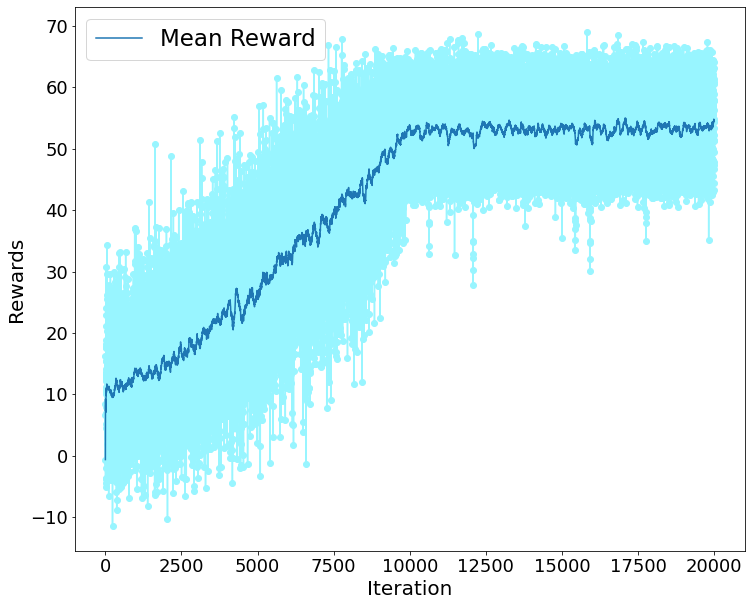

In [12]:
x = [i+1 for i in range(n_games)]
Plot_Strategy(scores,x,mean_rewards)

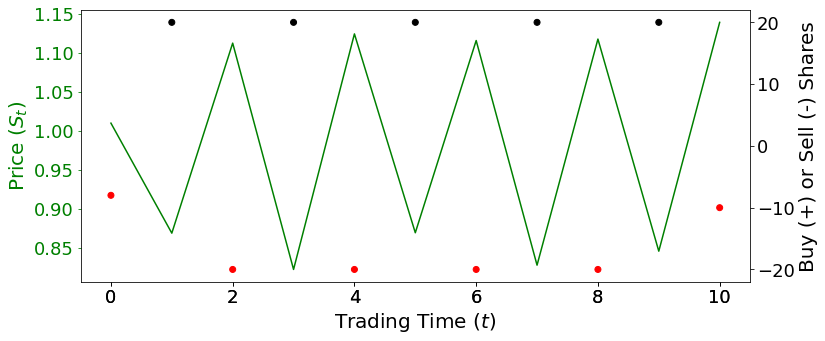

In [13]:
Plot_Strategy2(env.diff_inventory,env.St)

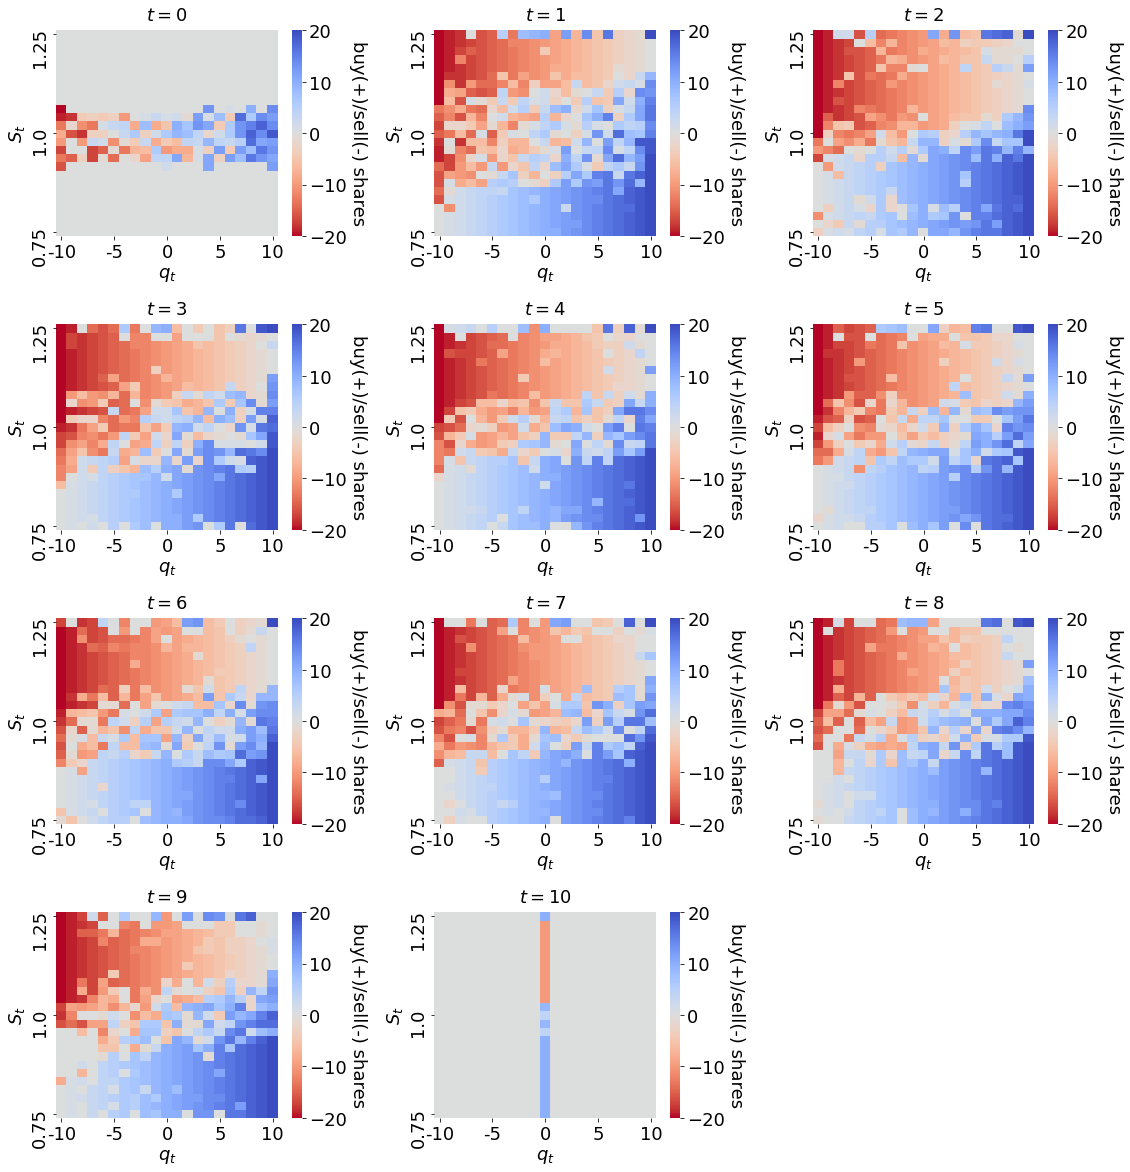

In [14]:
fig = plt.figure(figsize=(4*4,5*4))
for i in range(11):
    ax = fig.add_subplot(5,3,i+1)
    t_df = pd.DataFrame(data=env.q_table[i,:,:],index=np.round(env.St_bins,2),columns = env.action_space)
    sns.heatmap(t_df, vmin=-20, vmax=20, cbar_kws=dict(label="buy(+)/sell(-) shares",ticks=[-20,-10,0,10,20]), cmap=cm.coolwarm_r, xticklabels=5, yticklabels=12)
    ax.set_xlabel(r'$q_t$',fontsize=18)
    ax.set_ylabel(r'$S_t$',fontsize=18)
    ax.set_title(r'$t = $' + str(i),fontsize=18,pad=10)
    ax.invert_yaxis()
    ax.collections[0].colorbar.set_label("buy(+)/sell(-) shares",rotation=270, labelpad=20,fontsize=18)

plt.tight_layout()
plt.show()